In [41]:
import lzma
import pickle

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from neural_network import NeuralNetwork

In [42]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [43]:
import glob

RECORD_COUNT = len(glob.glob("../record_*")) 

# Load and preprocess your collected data


In [44]:
from statistics import mean

snapshots = []

for i in range(RECORD_COUNT):
    try:
        with lzma.open(f"../record_{i}.npz", "rb") as file:
            data = pickle.load(file)
            snapshots = snapshots + data
    except FileNotFoundError:
        print(f"Skipping record_{i}.npz - file not found")
    except Exception as e:
        print(f"Error processing record_{i}.npz: {e}")
        continue

Skipping record_11.npz - file not found
Skipping record_15.npz - file not found


# Helper functions for contextual analysis

In [45]:
def get_window(data, index, window_size=3):
    """Get previous and next snapshots around the given index"""
    start = max(0, index - window_size)
    end = min(len(data), index + window_size + 1)
    
    prev_snapshots = data[start:index] if index > 0 else []
    next_snapshots = data[index + 1:end] if index < len(data) - 1 else []
    
    return prev_snapshots, next_snapshots

def should_be_slow_snapshot(snapshot, prev_snapshots, next_snapshots):
    """Determine if this snapshot should be classified as 'slow' based on context"""
    # Current state
    current_speed = snapshot.car_speed
    min_distance = min(snapshot.raycast_distances)
    is_turning = snapshot.current_controls[2] or snapshot.current_controls[3]  # left or right
    
    # Analyze previous behavior (if available)
    is_decelerating = False
    if prev_snapshots:
        speed_trend = [s.car_speed for s in prev_snapshots + [snapshot]]
        is_decelerating = any(a > b for a, b in zip(speed_trend, speed_trend[1:]))
    
    # Analyze upcoming conditions (if available)
    approaching_obstacle = False
    upcoming_turn = False
    if next_snapshots:
        future_distances = [min(s.raycast_distances) for s in next_snapshots]
        approaching_obstacle = any(d < 30 for d in future_distances)
        
        # Check if turning in near future
        future_controls = [s.current_controls for s in next_snapshots]
        upcoming_turn = any(c[2] or c[3] for c in future_controls)  # any left or right controls
    
    # Classification rules
    return any([
        current_speed > 25,  # Current speed is high
        # min_distance < 20,   # Close to obstacle
        is_turning,         # Currently turning
        is_decelerating,    # Actively slowing down
        approaching_obstacle,# Obstacle ahead
        upcoming_turn       # Turn coming up
    ])

In [46]:
# all_snapshots = []

# # First, collect all snapshots
# for i in range(RECORD_COUNT):
#     try:
#         with lzma.open(f"../record_{i}.npz", "rb") as file:
#             data = pickle.load(file)
#             print(f"Processing record_{i}")
#             all_snapshots.extend(data)
#     except FileNotFoundError:
#         print(f"Skipping record_{i}.npz - file not found")
#     except Exception as e:
#         print(f"Error processing record_{i}.npz: {e}")
#         continue

# # Now analyze each snapshot with context
# snapshots = []
# for i in range(len(all_snapshots)):
#     snapshot = all_snapshots[i]
#     prev_snapshots, next_snapshots = get_window(all_snapshots, i)
    
#     if should_be_slow_snapshot(snapshot, prev_snapshots, next_snapshots):
#         snapshots.append(snapshot)

# print(f"\nTotal snapshots collected: {len(all_snapshots)}")
# print(f"Snapshots classified as 'slow': {len(snapshots)}")
# print(f"Percentage of slow snapshots: {100 * len(snapshots) / len(all_snapshots):.2f}%")

In [47]:
X_scalar_list = [
    [s.car_speed, *s.raycast_distances]
    for s in snapshots
]

# 2. Create the list of labels (y). The original list comprehension was a bit complex.
y_list = [s.current_controls for s in snapshots]

# 3. Convert all lists to NumPy arrays with a specific data type
features = np.array(X_scalar_list, dtype=np.float32)
labels = np.array(y_list, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define your neural network model


In [48]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
    (5): Sigmoid()
  )
)

# Set up training loop with loss function and optimizer

In [49]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)

# Look for Dropout (50%)

# Train the model and save checkpoints


In [50]:
from torch.utils.data import Dataset

class Data(Dataset):
    def __init__(self, X, y):
        self.features = torch.from_numpy(X.astype(np.float32))
        self.labels = torch.from_numpy(y.astype(np.float32))  # Changed from int32 to float32
        self.len = self.features.shape[0]
       
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
   
    def __len__(self):
        return self.len

In [51]:
batch_size = 32

train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [52]:
num_epochs = 100
train_loss_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for features, labels in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(features)
        loss = criterion(pred, labels)
        total_loss += loss.item()
        train_loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_dataloader)}")

Epoch 1, Loss: 0.42739557588504534
Epoch 2, Loss: 0.3929492833755784
Epoch 3, Loss: 0.389512365652343
Epoch 4, Loss: 0.38630489297842574
Epoch 5, Loss: 0.38313260245121133
Epoch 6, Loss: 0.3804176492711245
Epoch 7, Loss: 0.3804835813530421
Epoch 8, Loss: 0.37748534952179863
Epoch 9, Loss: 0.3748312025504597
Epoch 10, Loss: 0.37809429077778833
Epoch 11, Loss: 0.37175590330261293
Epoch 12, Loss: 0.37588364870871527
Epoch 13, Loss: 0.3684596299367436
Epoch 14, Loss: 0.36764304163092276
Epoch 15, Loss: 0.3708096341056339
Epoch 16, Loss: 0.3710175204580113
Epoch 17, Loss: 0.3732062055397842
Epoch 18, Loss: 0.368554744427487
Epoch 19, Loss: 0.3729319554769387
Epoch 20, Loss: 0.36944284151166173
Epoch 21, Loss: 0.36866170268947795
Epoch 22, Loss: 0.36605022948677257
Epoch 23, Loss: 0.36766707164756324
Epoch 24, Loss: 0.3656268180426905
Epoch 25, Loss: 0.36528338870759736
Epoch 26, Loss: 0.36559801081479604
Epoch 27, Loss: 0.36147788116487406
Epoch 28, Loss: 0.362606882038763
Epoch 29, Loss: 0

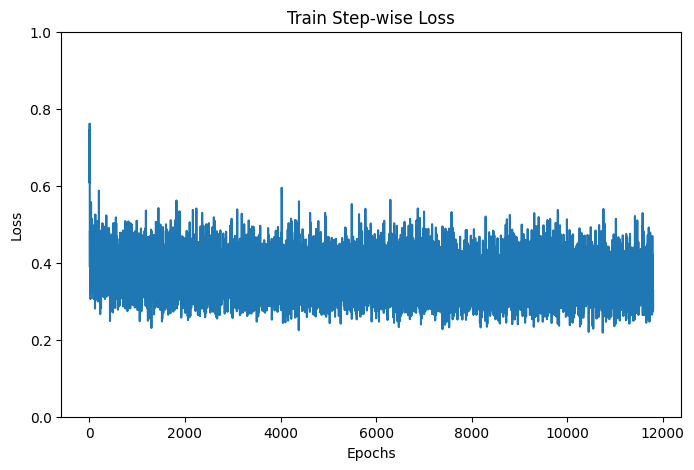

In [53]:
import matplotlib.pyplot as plt

step = range(len(train_loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(train_loss_values))
plt.title("Train Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0, 1))
plt.show()

# Evaluate performance on validation data


In [54]:
# Evaluate the model on test data
model.eval()
correct = 0
total = 0
loss = 0.0
test_loss_values = []
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_dataloader:
        outputs = model(features)  # Get model outputs (probabilities from sigmoid)
        
        # Convert probabilities to binary predictions (0 or 1)
        predicted = (outputs >= 0.5).float()
        
        # Calculate accuracy per element (since we have 4 outputs per sample)
        correct += (predicted == labels).sum().item()
        total += labels.numel()  # Total number of elements (batch_size * 4)
        test_loss_values.append(criterion(outputs, labels).item())
        loss += criterion(outputs, labels).item()

        # Store for later analysis if needed
        all_predictions.append(predicted.numpy())
        all_labels.append(labels.numpy())

# Calculate overall accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test set: {accuracy:.2f}%')
print(f'Total predictions: {total} (across {total//4} samples with 4 controls each)')

# Optionally, calculate per-control accuracy
all_predictions = np.vstack(all_predictions)
all_labels = np.vstack(all_labels)

print("\nPer-control accuracy:")
for i, control in enumerate(['Forward', 'Backward', 'Left', 'Right']):
    control_correct = (all_predictions[:, i] == all_labels[:, i]).sum()
    control_total = len(all_predictions)
    control_accuracy = 100 * control_correct / control_total
    print(f'  {control}: {control_accuracy:.2f}%')

Accuracy of the network on the test set: 82.07%
Total predictions: 3764 (across 941 samples with 4 controls each)

Per-control accuracy:
  Forward: 69.93%
  Backward: 94.37%
  Left: 87.35%
  Right: 76.62%


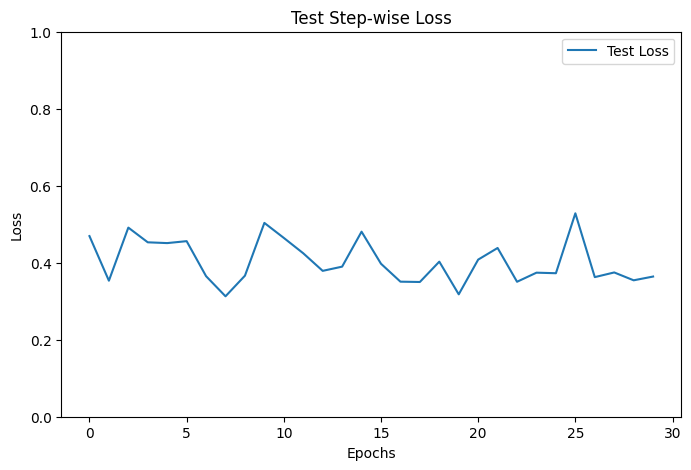

In [55]:
import matplotlib.pyplot as plt

step = range(len(test_loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(test_loss_values), label='Test Loss')
plt.title("Test Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0, 1))
plt.legend()
plt.show()

# Save the trained model

In [56]:
# Save the trained model
model_save_path = "car_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# You can also save with additional info
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'final_loss': train_loss_values[-1] if train_loss_values else None,
    'accuracy': accuracy
}
torch.save(checkpoint, "car_model_checkpoint.pth")
print("Checkpoint saved to car_model_checkpoint.pth")

Model saved to car_model.pth
Checkpoint saved to car_model_checkpoint.pth
